In [1]:
import pandas as pd 
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from scipy.optimize import least_squares
from enum import Enum
import warnings
warnings.filterwarnings('ignore')

In [2]:
swap = pd.read_csv('Swap.csv')
swap.index = swap['Tenor']
swap = swap.drop(columns=['Tenor'])
swap.columns.name='Expiry'
swap.columns = [1,5,10]
swap

,1,5,10
Tenor,,,
1,0.032007,0.039274,0.042189
2,0.033259,0.040075,0.043116
3,0.034011,0.040072,0.044097
5,0.035255,0.041093,0.046249
10,0.038428,0.043634,0.053458


In [3]:
irs = pd.read_csv('IRS.csv')
irs.head()

,Unnamed: 0,Tenor,Product,Rate,D~,Do,sum
0,0,0.5,LIBOR,0.025000,0.987654,0.998750,1.011234
1,1,1.0,IRS,0.028000,0.972577,0.997000,2.023691
2,2,1.5,NaN,0.029248,0.957378,0.995265,3.034756
3,3,2.0,IRS,0.030000,0.942179,0.993531,4.044314
4,4,2.5,NaN,0.030841,0.926330,0.991773,5.053056


In [4]:
Swapdata = pd.read_excel('IR Data.xlsx',sheet_name = 'Swaption')
Swapdata.columns = Swapdata.iloc[1,:]
Swapdata = Swapdata.iloc[2:]
Swapdata.reset_index(drop=True,inplace = True)
Swapdata.set_index(['Expiry','Tenor'],inplace = True)
Swapdata.columns.name = 'Strike'
Swapdata

Strike       -200bps -150bps -100bps  -50bps  -25bps    ATM +25bps +50bps  \
Expiry Tenor                                                                
1Y     1Y      91.57   62.03   44.13  31.224  26.182   22.5  20.96   21.4   
       2Y      83.27   61.24   46.57  35.807  31.712  28.72  27.12  26.84   
       3Y      73.92   56.87   44.77  35.745  32.317  29.78  28.29   27.8   
       5Y      55.19   44.64   36.51  30.242  27.851  26.07  24.98  24.56   
       10Y     41.18   35.04  30.207  26.619  25.351  24.47  23.98  23.82   
5Y     1Y       67.8   49.09    38.4  31.485   29.06  27.26  26.04  25.32   
       2Y      57.88   46.41  39.033  33.653  31.531  29.83  28.56  27.65   
       3Y      53.43   44.44   38.18  33.437  31.536  29.98  28.76  27.82   
       5Y      41.99  36.524  32.326  29.005  27.677   26.6  25.73  25.02   
       10Y    34.417  30.948  28.148  25.954  25.136  24.51  23.99  23.56   
10Y    1Y      55.16   44.32  37.368  32.259   30.21  28.54  27.31  26.45   
       2Y      51.17    42.9  37.078  32.622    30.8  29.28  28.09   27.2   
       3Y      48.22   41.43    36.4  32.439  30.796   29.4  28.27  27.38   
       5Y      40.55  35.891  32.181  29.144  27.857  26.74   25.8  25.02   
       10Y    33.601  30.509  27.978  25.926  25.086  24.37  23.76  23.24   

Strike       +100bps +150bps +200bps  
Expiry Tenor                          
1Y     1Y      24.34  27.488  30.297  
       2Y      28.51  31.025  33.523  
       3Y      28.77  30.725  32.833  
       5Y      25.12  26.536  28.165  
       10Y     24.25  25.204  26.355  
5Y     1Y      24.94   25.32   25.98  
       2Y      26.71   26.54   26.76  
       3Y      26.67    26.2   26.15  
       5Y      24.06   23.57    23.4  
       10Y     22.91   22.49   22.25  
10Y    1Y      25.61   25.52   25.78  
       2Y      26.12   25.72   25.71  
       3Y      26.18   25.58   25.37  
       5Y      23.87   23.17    22.8  
       10Y     22.44    21.9   21.56

# 1

In [5]:
class PayoffType(Enum):
    Call = 0
    Put = 1

def Black76(F,K,pvbp,T,sigma,PayoffType):
    d1 = (np.log(F/K) + (1/2) * (sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if PayoffType == PayoffType.Call:
        return pvbp*(F*norm.cdf(d1)-K*norm.cdf(d2))
    elif PayoffType == PayoffType.Put:
        return pvbp*(K*norm.cdf(-d2)-F*norm.cdf(-d1))

def DD(F,K,pvbp,T,sigma,beta,PayoffType):
    K = K + ((1-beta)/beta) * F
    F = F / beta
    sigma = sigma * beta
    if PayoffType == PayoffType.Call:
        return Black76(F, K, pvbp, T, sigma, PayoffType)
    elif PayoffType == PayoffType.Put:
        return Black76(F, K, pvbp, T, sigma, PayoffType)


In [6]:
Black76(0.032,0.012,0.9944,1,0.225,PayoffType.Put)

5.971268700832361e-09

In [7]:
DD(0.032,0.012,0.9944,1,0.225,0.7,PayoffType.Put)

1.685256689773884e-07

In [8]:
def ddcalibration(x, F, strikes, vols, pvbp, T):
    err = 0.0
    i = 0
    sigma = vols[5]
    for vol in vols:
        implied_vol = impliedVolatility(F, strikes[i], pvbp, T, sigma, x)
        err += (vol - implied_vol)**2
        i+=1
    return err

def impliedVolatility(F, K, pvbp, T, sigma, beta):
    try:
        if K >= F:
            price = DD(F, K, pvbp, T, sigma, beta, PayoffType.Call)
#             print(price)
            impliedVol = brentq(lambda x: price -
                                Black76(F,K,pvbp,T,x,PayoffType.Call),
                                1e-12, 10.0)
        elif K < F:
            price = DD(F, K, pvbp, T, sigma, beta, PayoffType.Put)
#             print(f"put{price}")
            impliedVol = brentq(lambda x: price -
                                Black76(F, K, pvbp, T, x, PayoffType.Put),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    
    except Exception:
        impliedVol = np.nan
    return impliedVol

In [9]:
df_Beta = pd.DataFrame(index=['1Y','5Y','10Y'],columns=['1Y','2Y','3Y','5Y','10Y'])
df_Beta.index.name = 'Expiry'
df_Beta.columns.name = 'Tenor'
df_Sigma = pd.DataFrame(index=['1Y','5Y','10Y'],columns=['1Y','2Y','3Y','5Y','10Y'])
df_Sigma.index.name = 'Expiry'
df_Sigma.columns.name = 'Tenor'

In [10]:
intialGuess = 0.7
K_array = np.array([-0.02,-0.015,-0.010,-0.005,-0.0025,0,0.0025,0.005,0.01,0.015,0.02])
vol_list = []
for expiry in [1,5,10]:
    for tenor in [1,2,3,5,10]:
        f1,f2 = f"{expiry}Y", f"{tenor}Y"
        T = expiry + tenor
        F = float(swap[expiry][swap.index==tenor].values)
        strikes = F + K_array
        vols = Swapdata[Swapdata.index == (f1, f2)].values[0]/100
        pvbp = 0.5 * sum(irs['Do'][(irs['Tenor']>expiry) & (irs['Tenor']<=T)])
#         print(vols[5],sigma)
#         print(F,strikes[0],vols,pvbp,expiry)
        res = least_squares(lambda x: ddcalibration(x,
                                                    F,
                                                    strikes,
                                                    vols,
                                                    pvbp,
                                                    expiry,
                                                   ),
                           intialGuess,
                           bounds = ([0,1])
                           )
        df_Beta.loc[f1,f2] = f"{res.x[0]:.5e}"
        df_Sigma.loc[f1,f2] = vols[5]
        
        for i in strikes:
            vol_list.append(impliedVolatility(F, i, pvbp, T, vols[5], float(df_Beta.loc[f1,f2]) ))

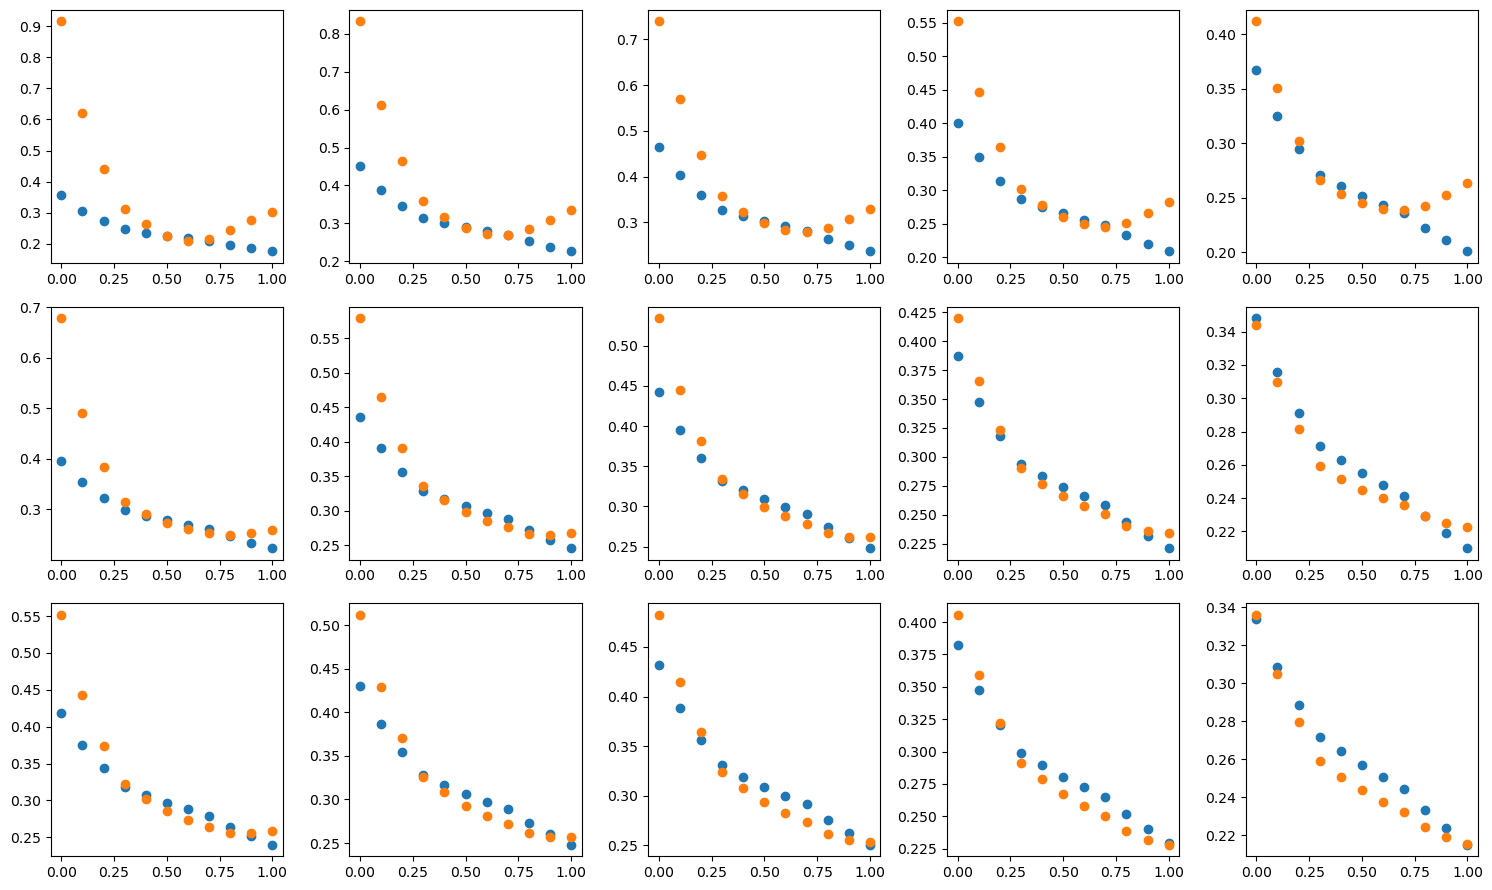

In [11]:
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
k=0
for i in range(3):
    for j in range(5):
        axs[i, j].scatter(np.arange(0.0,1.1,0.1),vol_list[k*11:(k+1)*11])
        axs[i, j].scatter(np.arange(0.0,1.1,0.1),Swapdata.iloc[k,:]/100)
        k+=1
#         axs[i, j].axis('off')
plt.tight_layout()

In [12]:
df_Beta

Tenor,1Y,2Y,3Y,5Y,10Y
Expiry,,,,,
1Y,1.48918e-12,8.97601e-08,7.67153e-13,3.77767e-06,2.48950e-05
5Y,8.97389e-07,1.57091e-07,1.57902e-05,7.31893e-06,5.77898e-02
10Y,5.17382e-07,5.11821e-08,1.62001e-06,6.13056e-05,6.45907e-04


In [13]:
df_Sigma

Tenor,1Y,2Y,3Y,5Y,10Y
Expiry,,,,,
1Y,0.225,0.2872,0.2978,0.2607,0.2447
5Y,0.2726,0.2983,0.2998,0.266,0.2451
10Y,0.2854,0.2928,0.294,0.2674,0.2437


# 2

In [14]:
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma


In [15]:
def sabrcalibration(x, F, strikes, vols, pvbp, T):
    err = 0.0
    sigma = vols[5]
    i = 0
    for vol in vols:
        err += (vol - SABR(F, strikes[i], T, x[0], 0.9, x[1], x[2]))**2
        i+=1
    return err

In [16]:
df_Alp = pd.DataFrame(index=['1Y','5Y','10Y'],columns=['1Y','2Y','3Y','5Y','10Y'])
df_Alp.index.name = 'Expiry'
df_Alp.columns.name = 'Tenor'
df_Nu = pd.DataFrame(index=['1Y','5Y','10Y'],columns=['1Y','2Y','3Y','5Y','10Y'])
df_Nu.index.name = 'Expiry'
df_Nu.columns.name = 'Tenor'
df_Rho = pd.DataFrame(index=['1Y','5Y','10Y'],columns=['1Y','2Y','3Y','5Y','10Y'])
df_Rho.index.name = 'Expiry'
df_Rho.columns.name = 'Tenor'

In [23]:
intialGuess = [0.02, 0.2, 0.1]
K_array = np.array([-0.02,-0.015,-0.010,-0.005,-0.0025,0,0.0025,0.005,0.01,0.015,0.02])
vol_list_2 = []
for expiry in [1,5,10]:
    for tenor in [1,2,3,5,10]:
        f1,f2 = f"{expiry}Y", f"{tenor}Y"
#         print(float(Swapdata['ATM'][Swapdata.index == (f1, f2)].values))
        T = expiry + tenor
        F = float(swap[expiry][swap.index==tenor].values)
        strikes = F + K_array
        vols = Swapdata[Swapdata.index == (f1, f2)].values[0]/100
        pvbp = 0.5 * sum(irs['Do'][(irs['Tenor']>expiry) & (irs['Tenor']<=T)])
#         print(F,strikes[0],vols,pvbp,expiry)
#         print(vols[5])
        res = least_squares(lambda x: sabrcalibration(x,
                                                    F,
                                                    strikes,
                                                    vols,
                                                    pvbp,
                                                    expiry,
                                                   ),
                           intialGuess,
                            bounds=([0,-1,0],[5,1,5])
                           )
        df_Alp.loc[f1,f2] = res.x[0]
        df_Rho.loc[f1,f2] = res.x[1]
        df_Nu.loc[f1,f2] = res.x[2]
        
        for i in strikes:
            vol_list_2.append(SABR(F, i, T, res.x[0], 0.9, res.x[1], res.x[2]))

In [18]:
df_Alp

Tenor,1Y,2Y,3Y,5Y,10Y
Expiry,,,,,
1Y,0.138832,0.184252,0.196243,0.17576,0.168894
5Y,0.166695,0.185392,0.192835,0.175902,0.161988
10Y,0.159855,0.177812,0.184844,0.167016,0.149519


In [19]:
df_Nu

Tenor,1Y,2Y,3Y,5Y,10Y
Expiry,,,,,
1Y,2.039811,1.676385,1.43947,1.083303,0.805349
5Y,1.341067,1.035611,0.925604,0.707394,0.576543
10Y,0.950868,0.88499,0.828162,0.701105,0.619678


In [20]:
df_Rho

Tenor,1Y,2Y,3Y,5Y,10Y
Expiry,,,,,
1Y,-0.627195,-0.520905,-0.477853,-0.392339,-0.239518
5Y,-0.586067,-0.480739,-0.466925,-0.401082,-0.271747
10Y,-0.471829,-0.483895,-0.477341,-0.416201,-0.303514


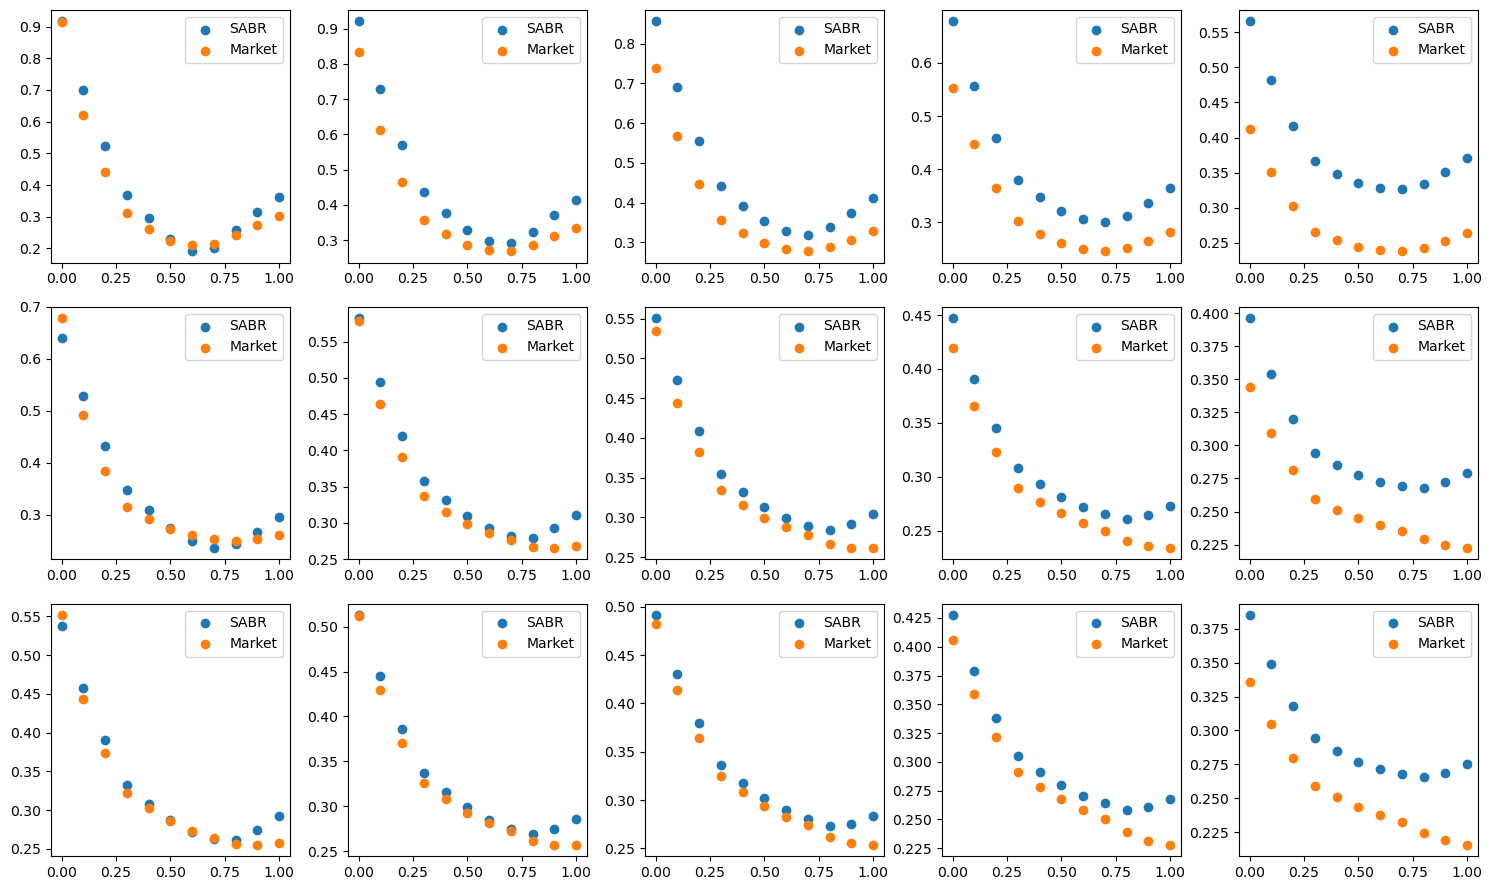

In [26]:
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
k=0
for i in range(3):
    for j in range(5):
        axs[i, j].scatter(np.arange(0.0,1.1,0.1),vol_list_2[k*11:(k+1)*11],label = 'SABR')
        axs[i, j].scatter(np.arange(0.0,1.1,0.1),Swapdata.iloc[k,:]/100,label = 'Market')
        axs[i, j].legend()

        k+=1
#         axs[i, j].axis('off')
plt.tight_layout()

# 3

 Price the following swaptions using the calibrated displaced-diffusion and
SABR model:

• payer 2y × 10y K = 1%, 2%, 3%, 4%, 5%, 6%, 7%, 8%

• receiver 8y × 10y K = 1%, 2%, 3%, 4%, 5%, 6%, 7%, 8%


In [149]:
k_range = [0.01*k for k in range(1,9)]
k_range

[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]

In [131]:
swap

,1,5,10
Tenor,,,
1,0.032007,0.039274,0.042189
2,0.033259,0.040075,0.043116
3,0.034011,0.040072,0.044097
5,0.035255,0.041093,0.046249
10,0.038428,0.043634,0.053458


In [134]:
### interpolation
F_2y = 3*swap.iloc[4,0]/4 + swap.iloc[4,1]/4

beta_2y = 3*float(df_Beta['10Y'][0])/4 + float(df_Beta['10Y'][1])/4
sigma_2y = 3*df_Sigma['10Y'][0]/4 + df_Sigma['10Y'][1]/4

alpha_2y = 3*df_Alp['10Y'][0]/4 + df_Alp['10Y'][1]/4
nu_2y = 3*df_Nu['10Y'][0]/4 + df_Nu['10Y'][1]/4
rho_2y = 3*df_Rho['10Y'][0]/4 + df_Rho['10Y'][1]/4


F_8y = 2*swap.iloc[4,1]/5 + 3*swap.iloc[4,2]/5

beta_8y = 2*float(df_Beta['10Y'][1])/5 + 3*float(df_Beta['10Y'][2])/5
sigma_8y = 2*df_Sigma['10Y'][1]/5 + 3*df_Sigma['10Y'][2]/5

alpha_8y = 2*df_Alp['10Y'][1]/5 + 3*df_Alp['10Y'][2]/5
nu_8y = 2*df_Nu['10Y'][1]/5 + 3*df_Nu['10Y'][2]/5
rho_8y = 2*df_Rho['10Y'][1]/5 + 3*df_Rho['10Y'][2]/5

0.0495279695012036


> payer

In [156]:
t1,t2 = 2,10
T = t1 + t2

pvbp_1 = 0.5 * sum(irs['Do'][(irs['Tenor']>t1) & (irs['Tenor']<=T)])
print(pvbp_1)

9.699536040303805


In [154]:
[DD(F_2y,k,pvbp_1,t1,sigma_2y,beta_2y,PayoffType.Call) for k in k_range]

[0.2890606973574963,
 0.19583039841405644,
 0.11312178302483263,
 0.05192340460024029,
 0.0176736132547576,
 0.004216125771932961,
 0.0006768005402485378,
 7.115486356454963e-05]

In [155]:
[Black76(F_2y,k,pvbp_1,t1,SABR(F_2y,k,t,alpha_2y,0.9,rho_2y,nu_2y),PayoffType.Call) for k in k_range]

[0.2884778511702924,
 0.19380486576354225,
 0.10939250499161751,
 0.04780501806967104,
 0.014957290356039887,
 0.003216147361243904,
 0.0004919808524435689,
 6.01837695633179e-05]

> receiver

In [157]:
t1, t2 = 8, 10
T = t1 + t2
pvbp_2 = 0.5 * sum(irs['Do'][(irs['Tenor']>t1) & (irs['Tenor']<=T)])
print(pvbp_2)

9.375970278061528


In [161]:
[DD(F_8y,k,pvbp_2,t1,sigma_8y,beta_8y,PayoffType.Put) for k in k_range]

[0.019101767772280055,
 0.033848835553376325,
 0.05623241186789209,
 0.08797268149634663,
 0.13022742254847794,
 0.18333164017969478,
 0.24672777446648456,
 0.3191095893449219]

In [162]:
[Black76(F_8y,k,pvbp_2,t1,SABR(F_8y,k,t1,alpha_8y,0.9,rho_8y,nu_8y),PayoffType.Put) for k in k_range]

[0.004990895812053228,
 0.016083222369447068,
 0.03502521830412764,
 0.06418251403441108,
 0.10585729263910669,
 0.16130483261038095,
 0.22969255786345416,
 0.30813914174363966]